In [0]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Saving utils.py to utils.py


Using TensorFlow backend.


# Initialize the setting

In [0]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [0]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 15 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 105
        self.filters = 32
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/JHMDB/'
C = Config()

In [0]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [0]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [0]:
DD_Net = build_DD_Net(C)
DD_Net.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 105)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 15, 2)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 256)       436544      M[0][0]                          
                                                                 P[0][0]                          
_______________________________________________________________________

## Train and test on GT_split 1

In [0]:
from google.colab import drive
import pickle
drive.mount('/content/drive')
DATA_PATH1 = "/content/drive/My Drive/Colab Notebooks/Data"
infile = open(DATA_PATH1+'/GT_train_1.pkl','rb')
Train = pickle.load(infile)
DATA_PATH2 = "/content/drive/My Drive/Colab Notebooks/Data"
testfile= open(DATA_PATH2+'/GT_test_1.pkl','rb')
Test = pickle.load(testfile)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

  5%|▍         | 20/433 [00:00<00:02, 191.11it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 176/176 [00:00<00:00, 197.47it/s]


In [0]:
import keras
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 433 samples, validate on 176 samples
Epoch 1/600





433/433 [==============================] - 7s 16ms/step - loss: 3.7296 - acc: 0.0462 - val_loss: 3.0325 - val_acc: 0.0682
Epoch 2/600
433/433 [==============================] - 1s 1ms/step - loss: 3.7516 - acc: 0.0600 - val_loss: 2.9996 - val_acc: 0.0795
Epoch 3/600
433/433 [==============================] - 1s 1ms/step - loss: 3.6395 - acc: 0.0554 - val_loss: 2.9780 - val_acc: 0.0909
Epoch 4/600
433/433 [==============================] - 1s 1ms/step - loss: 3.6590 - acc: 0.0462 - val_loss: 2.9555 - val_acc: 0.1080
Epoch 5/600
433/433 [==============================] - 1s 1ms/step - loss: 3.5207 - acc: 0.0670 - val_loss: 2.9302 - val_acc: 0.1250
Epoch 6/600
433/433 [==============================] - 1s 2ms/step - loss: 3.6604 - acc: 0.0600 - val_loss: 2.9057 - val_acc: 0.1477
Epoch 7/600
433/433 [==============================

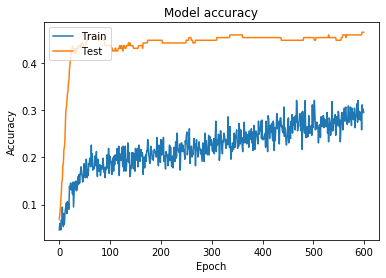

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 2

In [0]:

from google.colab import drive
import pickle
drive.mount('/content/drive')
DATA_PATH1 = "/content/drive/My Drive/Colab Notebooks/Data"
infile = open(DATA_PATH1+'/GT_train_2.pkl','rb')
Train = pickle.load(infile)
DATA_PATH2 = "/content/drive/My Drive/Colab Notebooks/Data"
testfile= open(DATA_PATH2+'/GT_test_2.pkl','rb')
Test = pickle.load(testfile)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 176/176 [00:00<00:00, 201.98it/s]


In [0]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [0]:
import keras
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    #callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

433/433 [==============================] - 9s 21ms/step - loss: 3.7063 - acc: 0.0508 - val_loss: 3.0227 - val_acc: 0.0909
Epoch 2/600
433/433 [==============================] - 1s 1ms/step - loss: 3.6033 - acc: 0.0647 - val_loss: 2.9970 - val_acc: 0.0966
Epoch 3/600
433/433 [==============================] - 1s 1ms/step - loss: 3.6726 - acc: 0.0693 - val_loss: 2.9758 - val_acc: 0.1193
Epoch 4/600
433/433 [==============================] - 1s 1ms/step - loss: 3.5312 - acc: 0.0739 - val_loss: 2.9552 - val_acc: 0.1193
Epoch 5/600
433/433 [==============================] - 1s 1ms/step - loss: 3.5226 - acc: 0.0647 - val_loss: 2.9302 - val_acc: 0.1307
Epoch 6/600
433/433 [==============================] - 1s 1ms/step - loss: 3.5432 - acc: 0.0855 - val_loss: 2.9115 - val_acc: 0.1364
Epoch 7/600
433/433 [==============================] - 1s 1ms/step - loss: 3.6235 - acc: 0.0716 - val_loss: 2.8901 - val_acc: 0.1477
Epoch 8/600
433/433 [==============================] - 1s 1ms/step - loss: 3.553

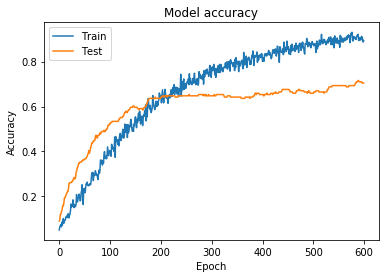

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [0]:
from google.colab import drive
import pickle
drive.mount('/content/drive')
DATA_PATH1 = "/content/drive/My Drive/Colab Notebooks/Data"
infile = open(DATA_PATH1+'/GT_train_3.pkl','rb')
Train = pickle.load(infile)
DATA_PATH2 = "/content/drive/My Drive/Colab Notebooks/Data"
testfile= open(DATA_PATH2+'/GT_test_3.pkl','rb')
Test = pickle.load(testfile)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 175/175 [00:00<00:00, 192.43it/s]


In [0]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [0]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

Train on 434 samples, validate on 175 samples
Epoch 1/600
434/434 [==============================] - 10s 23ms/step - loss: 3.7480 - acc: 0.0438 - val_loss: 2.9801 - val_acc: 0.1086
Epoch 2/600
434/434 [==============================] - 1s 1ms/step - loss: 3.4420 - acc: 0.0668 - val_loss: 2.8370 - val_acc: 0.1943
Epoch 3/600
434/434 [==============================] - 1s 1ms/step - loss: 3.2116 - acc: 0.0968 - val_loss: 2.7492 - val_acc: 0.2457
Epoch 4/600
434/434 [==============================] - 1s 1ms/step - loss: 3.0927 - acc: 0.1313 - val_loss: 2.6682 - val_acc: 0.3086
Epoch 5/600
434/434 [==============================] - 1s 1ms/step - loss: 2.9735 - acc: 0.1452 - val_loss: 2.6101 - val_acc: 0.3600
Epoch 6/600
434/434 [==============================] - 1s 1ms/step - loss: 2.8080 - acc: 0.1797 - val_loss: 2.5466 - val_acc: 0.3657
Epoch 7/600
434/434 [==============================] - 1s 1ms/step - loss: 2.7287 - acc: 0.1935 - val_loss: 2.4865 - val_acc: 0.3829
Epoch 8/600
434/434 [

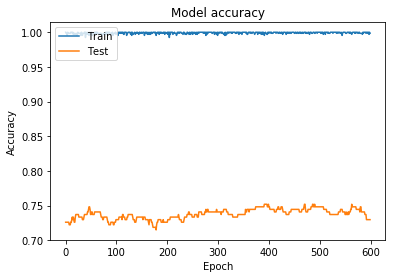

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculate average 

In [0]:
(0.73 + 0.74 + 0.74)/3

0.7366666666666667